In [2]:
# Cell 1: Import libraries
import sys
import os
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from src.models.cnn import SimpleCNN
from src.data.dataset import ChestXrayDataset
from src.utils.metrics import (
    evaluate_model,
    plot_confusion_matrix,
    print_classification_report,
    calculate_per_class_accuracy
)

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
# Cell 2: Load best model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = '../checkpoints/best_model.pth'

# Khởi tạo model
model = SimpleCNN(num_classes=4)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ Loaded best model from: {checkpoint_path}")
print(f"✅ Trained epochs: {checkpoint['epoch'] + 1}")
print(f"✅ Device: {device}")

✅ Loaded best model from: ../checkpoints/best_model.pth
✅ Trained epochs: 10
✅ Device: cuda


In [4]:
# Cell 3: Tạo test dataloader
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4909, 0.4930, 0.4941],
        std=[0.2407, 0.2408, 0.2414]
    )
])

test_dataset = ChestXrayDataset(
    root_dir='../data/processed/test',
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print(f"✅ Test samples: {len(test_dataset)}")
print(f"✅ Test batches: {len(test_loader)}")
print(f"✅ Classes: {test_dataset.classes}")

✅ Loaded 2471 images from ../data/processed/test
✅ Test samples: 2471
✅ Test batches: 78
✅ Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']


In [5]:
# Cell 4: Evaluate trên test set
print("🔍 Evaluating model on test set...")
print("=" * 70)

y_true, y_pred, y_probs = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

print(f"✅ Evaluation completed!")
print(f"Total test samples: {len(y_true)}")

🔍 Evaluating model on test set...
✅ Evaluation completed!
Total test samples: 2471


In [6]:
# Cell 5: Tính overall accuracy
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred) * 100
print(f"\n{'='*70}")
print(f"OVERALL TEST ACCURACY: {test_accuracy:.2f}%")
print(f"{'='*70}")


OVERALL TEST ACCURACY: 94.17%


✅ Confusion matrix saved to: ../results/figures/cnn_confusion_matrix.png


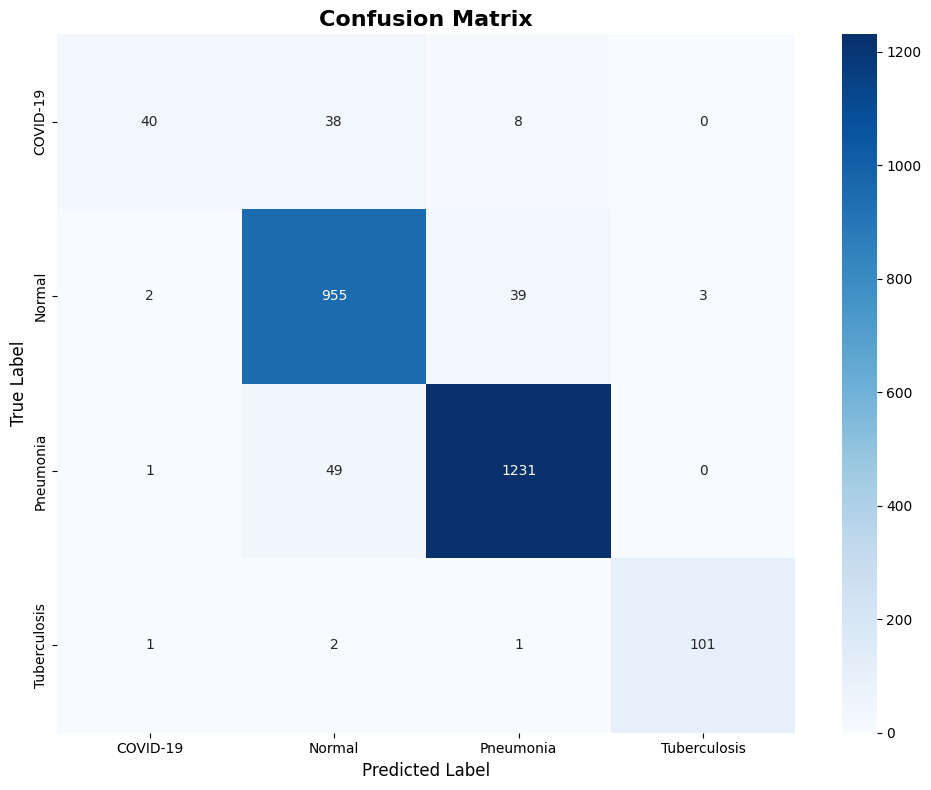

In [7]:
# Cell 6: Plot confusion matrix
os.makedirs('../results/figures', exist_ok=True)

cm = plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=test_dataset.classes,
    save_path='../results/figures/cnn_confusion_matrix.png'
)

In [8]:
# Cell 7: Print classification report
report = print_classification_report(
    y_true=y_true,
    y_pred=y_pred,
    class_names=test_dataset.classes
)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    COVID-19     0.9091    0.4651    0.6154        86
      Normal     0.9148    0.9560    0.9349       999
   Pneumonia     0.9625    0.9610    0.9617      1281
Tuberculosis     0.9712    0.9619    0.9665       105

    accuracy                         0.9417      2471
   macro avg     0.9394    0.8360    0.8696      2471
weighted avg     0.9417    0.9417    0.9390      2471



In [9]:
# Cell 8: Per-class accuracy
per_class_acc = calculate_per_class_accuracy(
    y_true=y_true,
    y_pred=y_pred,
    class_names=test_dataset.classes
)


PER-CLASS ACCURACY
COVID-19       : 46.51%
Normal         : 95.60%
Pneumonia      : 96.10%
Tuberculosis   : 96.19%


In [10]:
# Cell 9: Save results to file
results = {
    'overall_accuracy': float(test_accuracy),
    'per_class_accuracy': {
        class_name: float(acc * 100) 
        for class_name, acc in zip(test_dataset.classes, per_class_acc)
    },
    'classification_report': report
}

import json
results_file = '../results/metrics/cnn_test_results.json'
os.makedirs(os.path.dirname(results_file), exist_ok=True)

with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {results_file}")


✅ Results saved to: ../results/metrics/cnn_test_results.json
